# Image generation with DeepFloyd IF and OpenVINO™

DeepFloyd IF is an advanced open-source text-to-image model that delivers remarkable photorealism and language comprehension. DeepFloyd IF consists of a frozen text encoder and three cascaded pixel diffusion modules: a base model that creates 64x64 pixel images based on text prompts and two super-resolution models, each designed to generate images with increasing resolution: 256x256 pixel and 1024x1024 pixel. All stages of the model employ a frozen text encoder, built on the T5 transformer, to derive text embeddings, which are then passed to a UNet architecture enhanced with cross-attention and attention pooling.

### Text encoder impact

 - **Profound text prompt comprehension.**
The generation pipeline leverages the T5-XXL-1.1 Large Language Model (LLM) as a text encoder. Its intelligence is backed by a substantial number of text-image cross-attention layers, this ensures superior alignment between the prompt and the generated image.

 - **Realistic text in generated images.**
Capitalizing on the capabilities of the T5 model, DeepFloyd IF produces readable text depictions alongside objects with distinct attributes, which have typically been a challenge for most existing text-to-image models.


### DeepFloyd IF Distinctive Features

First of all, it is **Modular**.
DeepFloyd IF pipeline is a consecutive inference of several neural networks.

Which makes it **Cascaded**.
The base model generates low-resolution samples, then super-resolution models upsample the images to produce high-resolution results.
The models were individually trained at different resolutions. 

DeepFloyd IF employs **Diffusion** models. Diffusion models are machine learning systems that are trained to denoise random Gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have been shown to achieve state-of-the-art results for generating image data.

And finally, DeepFloyd IF operates in **Pixel** space. Unlike latent diffusion models (Stable Diffusion for instance), the diffusion is implemented on a pixel level.

![deepfloyd_if_scheme](https://github.com/deep-floyd/IF/raw/develop/pics/deepfloyd_if_scheme.jpg)

The graph above depicts the three-stage generation pipeline:
A text prompt is passed through the frozen T5-XXL LLM to convert it into a vector in embedded space. 

1. Stage 1: The first diffusion model in the cascade transforms the embedding vector into a 64x64 image. The DeepFloyd team has trained **three versions** of the base model, each with different parameters: IF-I 400M, IF-I 900M, and IF-I 4.3B. The smallest one is used by default, but users are free to change the checkpoint name to ["DeepFloyd/IF-I-L-v1.0"](https://huggingface.co/DeepFloyd/IF-I-L-v1.0) or ["DeepFloyd/IF-I-XL-v1.0"](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0)

2. Stage 2: To upscale the image, two text-conditional super-resolution models (Efficient U-Net) are applied to the output of the first diffusion model. The first of these upscales the sample from 64x64 pixel to 256x256 pixel resolution. Again, several versions of this model are available: IF-II 400M (default) and IF-II 1.2B (checkpoint name "DeepFloyd/IF-II-L-v1.0").

3. Stage 3: Follows the same path as Stage 2 and upscales the image to 1024x1024 pixel resolution. It is not released yet, so we will use a conventional Super Resolution network to get hi-res results.

#### Table of contents:
- [Prerequisites](#Prerequisites)
    - [Authentication](#Authentication)
- [DeepFloyd IF in Diffusers library](#DeepFloyd-IF-in-Diffusers-library)
- [Convert models to OpenVINO Intermediate representation (IR) format](#Convert-models-to-OpenVINO-Intermediate-representation-(IR)-format)
- [1. Convert Text Encoder](#1.-Convert-Text-Encoder)
- [Convert the first Pixel Diffusion module's UNet](#Convert-the-first-Pixel-Diffusion-module's-UNet)
- [Convert the second pixel diffusion module](#Convert-the-second-pixel-diffusion-module)
- [Prepare Inference pipeline](#Prepare-Inference-pipeline)
    - [Select inference device](#Select-inference-device)
- [Run Text-to-Image generation](#Run-Text-to-Image-generation)
    - [Text Encoder inference](#Text-Encoder-inference)
    - [First Stage diffusion block inference](#First-Stage-diffusion-block-inference)
    - [Second Stage diffusion block inference](#Second-Stage-diffusion-block-inference)
    - [Third Stage diffusion block](#Third-Stage-diffusion-block)
    - [Upscale the generated image using a Super Resolution network](#Upscale-the-generated-image-using-a-Super-Resolution-network)
        - [Download the Super Resolution model weights](#Download-the-Super-Resolution-model-weights)
        - [Reshape the model's inputs](#Reshape-the-model's-inputs)
        - [Prepare the input images and run the model](#Prepare-the-input-images-and-run-the-model)
        - [Display the result](#Display-the-result)
- [Try out the converted pipeline with Gradio](#Try-out-the-converted-pipeline-with-Gradio)
- [Next steps](#Next-steps)


> **NOTE**:

> - _This example requires the download of roughly 27 GB of model checkpoints, which could take some time depending on your internet connection speed. Additionally, the converted models will consume another 27 GB of disk space._
> - _Please be aware that a minimum of 32 GB of RAM is necessary to convert and run inference on the models. There may be instances where the notebook appears to freeze or stop responding._
> - _To access the model checkpoints, you'll need a Hugging Face account. You'll also be prompted to explicitly accept the [model license](https://huggingface.co/DeepFloyd/IF-I-M-v1.0)._

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required packages.

In [1]:
# Set up requirements

%pip install -q --upgrade pip
%pip install -q "transformers<4.30" "diffusers>=0.16.1,<0.22.0" accelerate safetensors sentencepiece huggingface_hub
%pip install -q "openvino>=2023.1.0" opencv-python
%pip install -q gradio

In [2]:
import gc
from pathlib import Path

from PIL import Image
from diffusers import DiffusionPipeline
import openvino as ov
import torch
from utils import TextEncoder, UnetFirstStage, UnetSecondStage, convert_result_to_image, download_omz_model

In [3]:
checkpoint_variant = 'fp16'
model_dtype = torch.float32
ir_input_type = ov.Type.f32
compress_to_fp16 = False

models_dir = Path('./models')
models_dir.mkdir(exist_ok=True)

encoder_ir_path = models_dir / 'encoder_ir.xml'
first_stage_unet_ir_path = models_dir / 'unet_ir_I.xml'
second_stage_unet_ir_path = models_dir / 'unet_ir_II.xml'

def pt_to_pil(images):
    """
    Convert a torch image to a PIL image.
    """
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).float().numpy()
    images = numpy_to_pil(images)
    return images


def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images

### Authentication
[back to top ⬆️](#Table-of-contents:)

In order to access IF checkpoints, users need to provide an authentication token.

If you already have a token, you can input it into the provided form in the next cell. If not, please proceed according to the following instructions:

1. Make sure to have a [Hugging Face](https://huggingface.co/) account and be logged in
2. Accept the license on the model card of [DeepFloyd/IF-I-M-v1.0](https://huggingface.co/DeepFloyd/IF-I-M-v1.0)
3. To generate a token, proceed to [this page](https://huggingface.co/settings/tokens)

Uncheck the `Add token as git credential?` box.

In [ ]:
from huggingface_hub import login

# Execute this cell to access the authentication form
login()

## DeepFloyd IF in Diffusers library
[back to top ⬆️](#Table-of-contents:)

To work with IF by DeepFloyd Lab, we will use [Hugging Face Diffusers package](https://github.com/huggingface/diffusers). Diffusers package exposes the `DiffusionPipeline` class, simplifying experiments with diffusion models. The code below demonstrates how to create a `DiffusionPipeline` using IF configs:

In [5]:
%%time

# Downloading the model weights may take some time. The approximate total checkpoints size is 27GB.
stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-M-v1.0",
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)

stage_2 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-M-v1.0",
    text_encoder=None,
    variant=checkpoint_variant,
    torch_dtype=model_dtype
)

safety_checker/model.safetensors not found

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.bin, text_encoder/pytorch_model.fp16-00001-of-00002.bin, text_encoder/pytorch_model.fp16-00002-of-00002.bin]
Loaded non-fp16 filenames:
[safety_checker/pytorch_model.bin, watermarker/diffusion_pytorch_model.bin
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 6.85 s, sys: 13.6 s, total: 20.5 s
Wall time: 6.9 s


## Convert models to OpenVINO Intermediate representation (IR) format
[back to top ⬆️](#Table-of-contents:)

Model conversion API enables direct conversion of PyTorch models. We will utilize the `ov.convert_model` method to acquire OpenVINO IR versions of the models. This requires providing a model object, input data for model tracing, and other relevant parameters.

The pipeline consists of three important parts:

 - A Text Encoder that translates user prompts to vectors in the latent space that the Diffusion model can understand.
 - A Stage 1 U-Net for step-by-step denoising latent image representation.
 - A Stage 2 U-Net that takes low resolution output from the previous step and the latent representations to upscale the resulting image.
 
Let us convert each part.

## 1. Convert Text Encoder
[back to top ⬆️](#Table-of-contents:)

The text encoder is responsible for converting the input prompt, such as "ultra close-up color photo portrait of rainbow owl with deer horns in the woods" into an embedding space that can be fed to the next stage's U-Net. Typically, it is a transformer-based encoder that maps a sequence of input tokens to a sequence of text embeddings.

The input for the text encoder consists of a tensor `input_ids`, which contains token indices from the text processed by the tokenizer and padded to the maximum length accepted by the model.

_Note_ the `input` argument passed to the `convert_model` method. The `convert_model` can be called with the `input shape` argument and/or the PyTorch-specific `example_input` argument. However, in this case, the tuple was utilized to describe the model input and provide it as the `input` argument. This solution offers a framework-agnostic solution and enables the definition of complex inputs. It allows specifying the input name, shape, type, and value within a single tuple, providing greater flexibility.

In [6]:
if not encoder_ir_path.exists():
    encoder_ir = ov.convert_model(
        stage_1.text_encoder,
        example_input=torch.ones(1, 77).long(),
        input=((1, 77), ov.Type.i64),
    )

    # Serialize the IR model to disk, we will load it at inference time
    ov.save_model(encoder_ir, encoder_ir_path, compress_to_fp16=compress_to_fp16)
    del encoder_ir

del stage_1.text_encoder

gc.collect();

## Convert the first Pixel Diffusion module's UNet
[back to top ⬆️](#Table-of-contents:)

U-Net model gradually denoises latent image representation guided by text encoder hidden state.

U-Net model has three inputs:

`sample` - latent image sample from previous step. Generation process has not been started yet, so you will use random noise.
`timestep` - current scheduler step.
`encoder_hidden_state` - hidden state of text encoder.
Model predicts the sample state for the next step.

The first Diffusion module in the cascade generates 64x64 pixel low resolution images.

In [7]:
if not first_stage_unet_ir_path.exists():
    unet_1_ir = ov.convert_model(
        stage_1.unet,
        example_input=(torch.ones(2, 3, 64, 64), torch.tensor(1).int(), torch.ones(2, 77, 4096)),
        input=[((2, 3, 64, 64), ir_input_type), ((), ov.Type.i32), ((2, 77, 4096), ir_input_type)],
    )

    ov.save_model(unet_1_ir, first_stage_unet_ir_path, compress_to_fp16=compress_to_fp16)

    del unet_1_ir

stage_1_config = stage_1.unet.config
del stage_1.unet

gc.collect();

## Convert the second pixel diffusion module
[back to top ⬆️](#Table-of-contents:)


The second Diffusion module in the cascade generates 256x256 pixel images.

The second stage pipeline will use bilinear interpolation to upscale the 64x64 image that was generated in the previous stage to a higher 256x256 resolution. Then it will denoise the image taking into account the encoded user prompt.

In [8]:
if not second_stage_unet_ir_path.exists():
    unet_2_ir = ov.convert_model(
        stage_2.unet,
        example_input=(
            torch.ones(2, 6, 256, 256),
            torch.tensor(1).int(),
            torch.ones(2, 77, 4096),
            torch.ones(2).int(),
        ),
        input=[
            ((2, 6, 256, 256), ir_input_type),
            ((), ov.Type.i32),
            ((2, 77, 4096), ir_input_type),
            ((2,), ov.Type.i32),
        ],
    )

    ov.save_model(unet_2_ir, second_stage_unet_ir_path, compress_to_fp16=compress_to_fp16)

    del unet_2_ir

stage_2_config = stage_2.unet.config
del stage_2.unet

gc.collect();

## Prepare Inference pipeline
[back to top ⬆️](#Table-of-contents:)

The original pipeline from the source repository will be reused in this example. In order to achieve this, adapter classes were created to enable OpenVINO models to replace Pytorch models and integrate seamlessly into the pipeline.

In [9]:
core = ov.Core()

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [10]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='CPU',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'GPU', 'AUTO'), value='GPU')

## Run Text-to-Image generation
[back to top ⬆️](#Table-of-contents:)

Now, we can set a text prompt for image generation and execute the inference pipeline. Optionally, you can also modify the random generator seed for latent state initialization and adjust the number of images to be generated for the given prompt.

### Text Encoder inference
[back to top ⬆️](#Table-of-contents:)


Inferring model in FP16 on GPU significantly increases performance and reduces required memory, but it may lead to lesser accuracy on some models. Particularly stage_1.text_encoder suffers from that. To avoid this effect we should calibrate some layer's precision, partially_upcast_nodes_to_fp32 helper upcasts only most precision-sensitive nodes to FP32 so that accuracy is restored while most of the nodes remain in FP16. With that inference performance remains comparable with full FP16.

In [11]:
# Fetch `model_upcast_utils` which helps to restore accuracy when inferred on GPU
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/model_upcast_utils.py',
    filename='model_upcast_utils.py'
)
from model_upcast_utils import is_model_partially_upcasted, partially_upcast_nodes_to_fp32

encoder_ov_model = core.read_model(encoder_ir_path)
if 'GPU' in core.available_devices and not is_model_partially_upcasted(encoder_ov_model):
    example_input_prompt = 'ultra close color photo portrait of rainbow owl with deer horns in the woods'
    text_inputs = stage_1.tokenizer(example_input_prompt, max_length=77, padding="max_length", return_tensors="np")
    upcasted_ov_model = partially_upcast_nodes_to_fp32(encoder_ov_model, text_inputs.input_ids)
    del encoder_ov_model
    gc.collect();

    import os
    os.remove(encoder_ir_path)
    os.remove(str(encoder_ir_path).replace('.xml', '.bin'))
    ov.save_model(upcasted_ov_model, encoder_ir_path, compress_to_fp16=compress_to_fp16)

In [12]:
%%time

prompt = 'ultra close color photo portrait of rainbow owl with deer horns in the woods'
negative_prompt = 'blurred unreal uncentered occluded'

# Initialize TextEncoder wrapper class
stage_1.text_encoder = TextEncoder(encoder_ir_path, dtype=model_dtype, device=device.value)
print('The model has been loaded')

# Generate text embeddings
prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt, negative_prompt=negative_prompt)

# Delete the encoder to free up memory
del stage_1.text_encoder.encoder_openvino
gc.collect()

The model has been loaded


/home/epavel/opt/envs/py310-dev/lib/python3.10/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `unet` directly via 'IFPipeline' object attribute is deprecated. Please access 'unet' over 'IFPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


CPU times: user 9.29 s, sys: 8.35 s, total: 17.6 s
Wall time: 16.5 s


0

### First Stage diffusion block inference
[back to top ⬆️](#Table-of-contents:)


The model has been loaded


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 39.7 s, sys: 15.4 s, total: 55.1 s
Wall time: 32.5 s


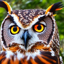

In [13]:
%%time

# Changing the following parameters will affect the model output
# Note that increasing the number of diffusion steps will increase the inference time linearly.
RANDOM_SEED = 42
N_DIFFUSION_STEPS = 50

# Initialize the First Stage UNet wrapper class
stage_1.unet = UnetFirstStage(
    first_stage_unet_ir_path,
    stage_1_config,
    dtype=model_dtype,
    device=device.value
)
print('The model has been loaded')

# Fix PRNG seed
generator = torch.manual_seed(RANDOM_SEED)

# Inference
image = stage_1(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
                generator=generator, output_type="pt", num_inference_steps=N_DIFFUSION_STEPS).images

# Delete the model to free up memory
del stage_1.unet.unet_openvino
gc.collect()

# Show the image
pt_to_pil(image)[0]

### Second Stage diffusion block inference
[back to top ⬆️](#Table-of-contents:)


The model has been loaded


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 59.8 s, sys: 36.4 s, total: 1min 36s
Wall time: 1min 14s


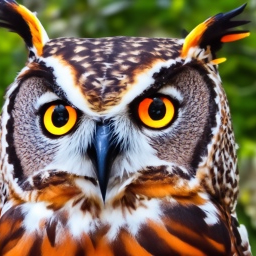

In [14]:
%%time

# Initialize the Second Stage UNet wrapper class
stage_2.unet = UnetSecondStage(
    second_stage_unet_ir_path,
    stage_2_config,
    dtype=model_dtype,
    device=device.value
)
print('The model has been loaded')

image = stage_2(
    image=image, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
    generator=generator, output_type="pt", num_inference_steps=20).images

# Delete the model to free up memory
del stage_2.unet.unet_openvino
gc.collect()

# Show the image
pil_image = pt_to_pil(image)[0]
pil_image

### Third Stage diffusion block
[back to top ⬆️](#Table-of-contents:)

The final block, which upscales images to a higher resolution (1024x1024 px), has not been released by DeepFloyd yet. Stay tuned!

### Upscale the generated image using a Super Resolution network
[back to top ⬆️](#Table-of-contents:)

Though the third stage has not been officially released, we'll employ the Super Resolution network from [Example #202](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/202-vision-superresolution/202-vision-superresolution-image.ipynb) to enhance our low-resolution result!

Note, this step will be substituted with the Third IF stage upon its release!

In [15]:
# Temporary requirement
!pip install -q matplotlib

#### Download the Super Resolution model weights
[back to top ⬆️](#Table-of-contents:)


In [16]:
import cv2
import numpy as np

# 1032: 4x superresolution, 1033: 3x superresolution
model_name = 'single-image-super-resolution-1032'
download_omz_model(model_name, models_dir)

sr_model_xml_path = models_dir / f'{model_name}.xml'

single-image-super-resolution-1032 already downloaded to models


#### Reshape the model's inputs
[back to top ⬆️](#Table-of-contents:)

We need to reshape the inputs for the model. This is necessary because the IR model was converted with a different target input resolution.
The Second IF stage returns 256x256 pixel images. Using the 4x Super Resolution model makes our target image size 1024x1024 pixel.

In [17]:
model = core.read_model(model=sr_model_xml_path)
model.reshape({
    0: [1, 3, 256, 256],
    1: [1, 3, 1024, 1024]
})
compiled_sr_model = core.compile_model(model=model, device_name=device.value)

#### Prepare the input images and run the model
[back to top ⬆️](#Table-of-contents:)


In [18]:
original_image = np.array(pil_image)
bicubic_image = cv2.resize(
    src=original_image, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC
)

# Reshape the images from (H,W,C) to (N,C,H,W) as expected by the model.
input_image_original = np.expand_dims(original_image.transpose(2, 0, 1), axis=0)
input_image_bicubic = np.expand_dims(bicubic_image.transpose(2, 0, 1), axis=0)

# Model Inference
result = compiled_sr_model(
    [input_image_original, input_image_bicubic]
)[compiled_sr_model.output(0)]

#### Display the result
[back to top ⬆️](#Table-of-contents:)


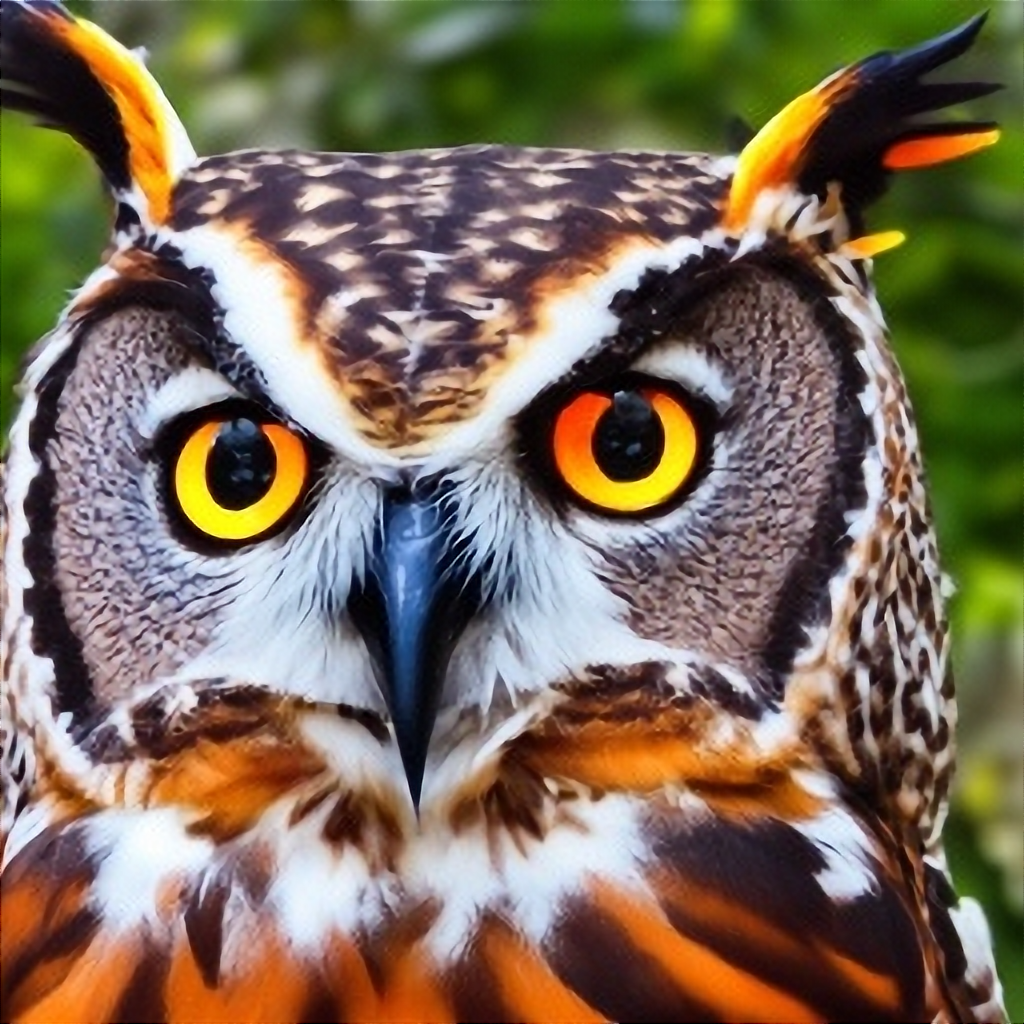

In [19]:
img = convert_result_to_image(result)
img

## Try out the converted pipeline with Gradio
[back to top ⬆️](#Table-of-contents:)

The demo app below is created using [Gradio package](https://www.gradio.app/docs/interface)

In [ ]:
# Build up the pipeline
stage_1.text_encoder = TextEncoder(encoder_ir_path, dtype=model_dtype, device=device.value)
print('The model has been loaded')

stage_1.unet = UnetFirstStage(
    first_stage_unet_ir_path,
    stage_1_config,
    dtype=model_dtype,
    device=device.value
)
print('The Stage-1 UNet has been loaded')

stage_2.unet = UnetSecondStage(
    second_stage_unet_ir_path,
    stage_2_config,
    dtype=model_dtype,
    device=device.value
)
print('The Stage-2 UNet has been loaded')

generator = torch.manual_seed(RANDOM_SEED)

# Combine the models' calls into a single `_generate` function
def _generate(prompt, negative_prompt):
    # Text encoder inference
    prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt, negative_prompt=negative_prompt)
    # Stage-1 UNet Inference
    image = stage_1(
        prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
        generator=generator, output_type="pt", num_inference_steps=N_DIFFUSION_STEPS
    ).images
    # Stage-2 UNet Inference
    image = stage_2(
        image=image, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds,
        generator=generator, output_type="pt", num_inference_steps=20
    ).images
    # Infer Super Resolution model
    original_image = np.array(pt_to_pil(image)[0])
    bicubic_image = cv2.resize(
        src=original_image, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC
    )
    # Reshape the images from (H,W,C) to (N,C,H,W) as expected by the model.
    input_image_original = np.expand_dims(original_image.transpose(2, 0, 1), axis=0)
    input_image_bicubic = np.expand_dims(bicubic_image.transpose(2, 0, 1), axis=0)
    # Model Inference
    result = compiled_sr_model(
        [input_image_original, input_image_bicubic]
    )[compiled_sr_model.output(0)]
    return convert_result_to_image(result)

In [ ]:
import gradio as gr

demo = gr.Interface(
    _generate,
    inputs=[
        gr.Textbox(label="Text Prompt"),
        gr.Textbox(label="Negative Text Prompt"),
    ],
    outputs=[
        "image"
    ],
    examples=[
        [
            "ultra close color photo portrait of rainbow owl with deer horns in the woods",
            "blurred unreal uncentered occluded"
        ],
        [
            "A scaly mischievous dragon is driving the car in a street art style",
            "blurred uncentered occluded"
        ],
    ],
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)

# If you are launching remotely, specify server_name and server_port
# EXAMPLE: `demo.launch(server_name='your server name', server_port='server port in int')`
# To learn more please refer to the Gradio docs: https://gradio.app/docs/

## Next steps
[back to top ⬆️](#Table-of-contents:)

Open the [238-deep-floyd-if-optimize](238-deep-floyd-if-optimize.ipynb) notebook to quantize stage 1 and stage 2 U-Net models with the Post-training Quantization API of NNCF and compress weights of the text encoder. Then compare the converted and optimized OpenVINO models.